The AdjointSecondOrderODEModel seeks to infer the forcing functon of a linear second order differential equation of the form:

\begin{equation}
-K_0\frac{d^2x}{dt^2}+u\frac{dx}{dt}+\eta_0 x(t)=f(t)
\end{equation}
with initial conditions:

\begin{equation}
x(0)=0
\end{equation}
and
\begin{equation}
\frac{dx(0)}{dt}=0
\end{equation}

The forcing function, $f$ is approximated using Random Fourier Features so that

\begin{equation}
f(t)\sim \sum_{i=1}^{M}\phi_i(t)z_i
\end{equation}

$f$ is then inferred using the adjoint method as in Gahungu et al. (2022).

# Import Modules

In [1]:
#numpy
import numpy as np
from numpy.random import multivariate_normal #For later example

#advectionGP
from advectionGP.models import AdjointShiftOperator1DModel as Model #Model module builds basic parts of the ODE problem, combines other classes into full model

'''To use other models in the class, such as the Advection Diffusion Reaction model, 
replace "AdjointSecondOrderODEModel" in the line above with "AdjointAdvectionDiffusionReaction" model
and adjust parameters as appropriate'''

from advectionGP.sensors import FixedSensorModel #Builds sensor arrays to generate data for foward model or to generate observations for comparison
from advectionGP.kernels import EQ #Generates exponentiated quadratic kernel approximation
from advectionGP.test import TestKernels #Unit test model


#Plotting tools
import matplotlib.pyplot as plt

# Establish Sensor Array

Our sensor matrix, X, is an array that has an element for each observation, which consists of the start and end times of the observation period. 

In [57]:
avg=0.01 # time that an observation is taken for
tlocL = np.linspace(1,9,10) # observation start times
X= np.zeros((len(tlocL),2)) # initiate X
# Build sensor locations
X[:,0] = tlocL #lower time
X[:,1] = X[:,0]+avg # upper time

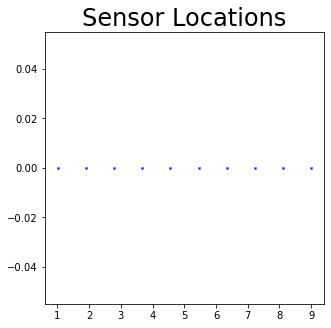

In [58]:
plt.rcParams["figure.figsize"] = (5,5)

#plt.xlim(0,10)
plt.title("Sensor Locations",fontsize=24)
plt.plot((X[:,1]-avg/2),np.zeros(len(X)),'xk',markersize=2,color='b');

Using X with then initalise our sensor model, which is used to calculate filter functions.

In [59]:
sensors = FixedSensorModel(X,0) # establish sensor model arguments are sensor locations and spatial averaging (not applicable in 1D case so set to 0)

# Forward Model Example

Here we generate an artificial source and concentration field using the tools in advectionGP.models. The source is generated over a Nt=100 grid in time.

### Establish forward model parameters

In [60]:
k_0 = -0.5 #Diffusion coefficient
u=1
eta=5
noiseSD = 0.05 #Observation noise
N_feat=2000 # number of features used to approximate ground truth GP
boundary = ([0],[10])# edges of the grid - in units of time
kForward = EQ(0.6, 1.0) # generate EQ kernel arguments are lengthscale and variance
res = [200] # grid size for time

### Initialise model and calculate ground truth source, concentration and observations

Here we use a constant source at a fixed location, but include code (commented out) for a source term calculated by approximating a gaussian process with an EQ kernel. Any source of the right dimensions can be used to simulate the forward problem.

In [61]:
a=100
m = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=kForward,sensormodel=sensors,a=a) #initiate PDE model to build concentration

dt,dt2,Nt = m.getGridStepSize() # useful numbers!

z=np.random.normal(0,1.0,N_feat) # Generate z to compute source
sourceGT=m.computeSourceFromPhi(z,m.shiftCoords)# Compute ground truth source by approximating GP
#sourceGT = np.ones(m.resolution)  # Example constant source
#sourceGT=np.zeros(m.resolution)
#sourceGT[10:50]=10
#sourceGT[50:60]=10
#sourceGT[80:90]=10
#sourceGT[sourceGT<0]=0
#concTrain=m.computeConcentration(sourceGT) # Compute concentration - runs ODE forward model
#concTrain[concTrain<0]=0
#m.concentration=concTrain

#sourceGT=np.zeros(m.resolution+int(m.a/dt))
#sourceGT[40:70]=10
concTrain=m.computeConcentration(sourceGT)

yTrain= m.computeObservations(addNoise='TRUE') # Compute observations with noise uses m.sensormodel for observation locations

# Inverse Problem Example

In [62]:
#%%timeit
#boundary = ([0],[10])# edges of the grid - in units of time
N_feat =1000 #Number of features used to infer the source
kInverse = EQ(0.6, 1) # Initiate kernel for inverse problem
mInfer = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=kInverse,sensormodel=sensors,a=a) #Initiate new model for inference
mInfer.computeModelRegressors() # Compute regressor matrix 
meanZ, covZ = mInfer.computeZDistribution(yTrain) # Infers z vector mean and covariance using regressor matrix
sourceInfer = mInfer.computeSourceFromPhi(meanZ,mInfer.shiftCoords) # Generates estimated source using mean of the inferred distribution
concInfer=mInfer.computeConcentration(sourceInfer) # Generates estimated concentration from inferred source


Getting Grid Step Size
Building X matrix
Calculating Adjoints...
9/10 
Calculating Phis...
999/1000 
Calculating SS
Inverting SS
Computing meanZ
Done


In [63]:
np.mean((sourceInfer-sourceGT)**2)#

0.758080162952351

In [64]:
np.mean((concTrain-concInfer)**2)

0.1259314682060039

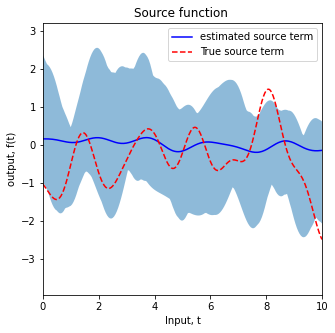

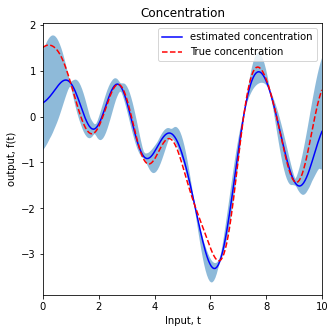

In [65]:
source_samples = []
conc_samples=[]    
for z_samp in np.random.multivariate_normal(meanZ, covZ,10):
    source_samples.append(mInfer.computeSourceFromPhi(z_samp,mInfer.shiftCoords))
    conc_samples.append(mInfer.computeConcentration(mInfer.computeSourceFromPhi(z_samp,mInfer.shiftCoords)))
source_samples=np.array(source_samples)
conc_samples=np.array(conc_samples)

source_lower_ci = np.percentile(source_samples,2.5,0)
source_upper_ci = np.percentile(source_samples,97.5,0)
source_mean = np.percentile(source_samples,50,0)

conc_lower_ci = np.percentile(conc_samples,2.5,0)
conc_upper_ci = np.percentile(conc_samples,97.5,0)
conc_mean = np.percentile(conc_samples,50,0)

xtest=np.arange(Nt+int(a/dt))
xtest=mInfer.shiftCoords.flatten()
#plt.figure(figsize=(15, 10))

plt.plot(xtest,sourceInfer,'b-')
plt.plot(xtest,sourceGT,'r--')

#plt.plot(xtest,source_samples.T,'g-',alpha=0.3)
#plt.fill_between(xtest,s_z_l,s_z_upper,alpha=0.5)
plt.fill_between(xtest,source_lower_ci,source_upper_ci,alpha=0.5)
plt.legend(labels=["estimated source term","True source term"])
plt.title("Source function ")
plt.xlabel("Input, t")
plt.ylabel("output, f(t)")
#plt.ylim([-5,5])
plt.xlim([0,10])
plt.savefig('NumberFeature%d.pdf' % N_feat)
plt.show()

#plt.figure(figsize=(15, 10))
xtest=np.arange(Nt)
xtest=mInfer.coords.flatten()
plt.plot(xtest,concInfer,'b-')
plt.plot(xtest,concTrain,'r--')

#plt.plot(xtest,source_samples.T,'g-',alpha=0.3)
#plt.fill_between(xtest,s_z_l,s_z_upper,alpha=0.5)
plt.fill_between(xtest,conc_lower_ci,conc_upper_ci,alpha=0.5)
plt.legend(labels=["estimated concentration","True concentration"])
plt.title("Concentration")
plt.xlabel("Input, t")
plt.ylabel("output, f(t)")
#plt.ylim([-5,5])
plt.xlim([0,10])
plt.savefig('NumberFeature%d.pdf' % N_feat)
plt.show()

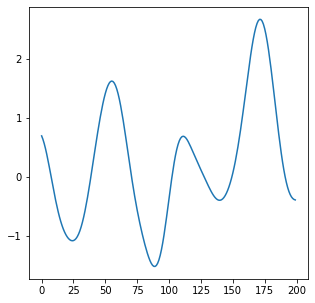

In [55]:
plt.plot(concTrain)

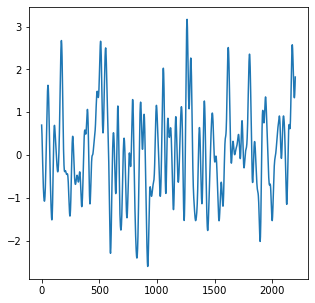

In [56]:
plt.plot(sourceGT)

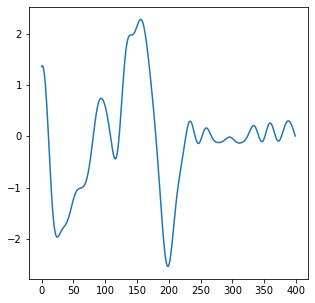

In [18]:
plt.plot(sourceInfer)

In [19]:
X

array([[0.        , 0.01      ],
       [0.52105263, 0.53105263],
       [1.04210526, 1.05210526],
       [1.56315789, 1.57315789],
       [2.08421053, 2.09421053],
       [2.60526316, 2.61526316],
       [3.12631579, 3.13631579],
       [3.64736842, 3.65736842],
       [4.16842105, 4.17842105],
       [4.68947368, 4.69947368],
       [5.21052632, 5.22052632],
       [5.73157895, 5.74157895],
       [6.25263158, 6.26263158],
       [6.77368421, 6.78368421],
       [7.29473684, 7.30473684],
       [7.81578947, 7.82578947],
       [8.33684211, 8.34684211],
       [8.85789474, 8.86789474],
       [9.37894737, 9.38894737],
       [9.9       , 9.91      ]])

In [20]:
#%%timeit
N_feat =10000 #Number of features used to infer the source
kInverse = EQ(0.6, 1) # Initiate kernel for inverse problem
mInfer = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=kInverse,sensormodel=sensors,k_0=k_0,u=u,eta=eta) #Initiate new model for inference
mInfer.computeModelRegressors(compact=True) # Compute regressor matrix 
meanZ, covZ = mInfer.computeZDistribution(yTrain) # Infers z vector mean and covariance using regressor matrix
sourceInfer = mInfer.computeSourceFromPhi(meanZ,compact=True) # Generates estimated source using mean of the inferred distribution
concInfer=mInfer.computeConcentration(sourceInfer) # Generates estimated concentration from inferred source


TypeError: __init__() got an unexpected keyword argument 'k_0'

In [ ]:
np.mean((sourceInfer-sourceGT)**2)

In [ ]:
np.mean((concTrain-concInfer)**2)

In [ ]:
source_samples = []
conc_samples=[]    
for z_samp in np.random.multivariate_normal(meanZ, covZ,200):
    source_samples.append(mInfer.computeSourceFromPhi(z_samp,compact=True))
    conc_samples.append(mInfer.computeConcentration(mInfer.computeSourceFromPhi(z_samp,compact=True)))
source_samples=np.array(source_samples)
conc_samples=np.array(conc_samples)

source_lower_ci = np.percentile(source_samples,2.5,0)
source_upper_ci = np.percentile(source_samples,97.5,0)
source_mean = np.percentile(source_samples,50,0)

conc_lower_ci = np.percentile(conc_samples,2.5,0)
conc_upper_ci = np.percentile(conc_samples,97.5,0)
conc_mean = np.percentile(conc_samples,50,0)

xtest=np.arange(Nt)

#plt.figure(figsize=(15, 10))

plt.plot(xtest,sourceInfer,'b-')
plt.plot(xtest,sourceGT,'r--')

#plt.plot(xtest,source_samples.T,'g-',alpha=0.3)
#plt.fill_between(xtest,s_z_l,s_z_upper,alpha=0.5)
plt.fill_between(xtest,source_lower_ci,source_upper_ci,alpha=0.5)
plt.legend(labels=["estimated source term","True source term"])
plt.title("Source function ")
plt.xlabel("Input, t")
plt.ylabel("output, f(t)")
#plt.ylim([-5,5])
plt.savefig('NumberFeature%d.pdf' % N_feat)
plt.show()

#plt.figure(figsize=(15, 10))

plt.plot(xtest,concInfer,'b-')
plt.plot(xtest,concTrain,'r--')

#plt.plot(xtest,source_samples.T,'g-',alpha=0.3)
#plt.fill_between(xtest,s_z_l,s_z_upper,alpha=0.5)
plt.fill_between(xtest,conc_lower_ci,conc_upper_ci,alpha=0.5)
plt.legend(labels=["estimated concentration","True concentration"])
plt.title("Concentration")
plt.xlabel("Input, t")
plt.ylabel("output, f(t)")
#plt.ylim([-5,5])
plt.savefig('NumberFeature%d.pdf' % N_feat)
plt.show()

In [ ]:
for h in m.kernel.getPhi1DCompact(m.mu,m.coords):
    plt.plot(h)

In [ ]:
for h in m.sensormodel.getHs1D(m):
    print(np.sum(h)*dt)

In [ ]:
ls = np.linspace(0.1,1,10)
sigma2s = np.linspace(1,10,9)
mInfer.kernel.sigma2

In [ ]:
minArray = np.zeros((10,2))

for l in range(10):

    mInfer = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=kInverse,sensormodel=sensors,k_0=k_0,u=u,eta=eta) #Initiate new model for inference
    MSEsource = np.zeros((len(ls),len(sigma2s)))
    reps=100

    for i,length in enumerate(ls):
        for j, var in enumerate(sigma2s):
            mInfer.kernel.l2=np.array([length])
            mInfer.kernel.sigma2=var
            mInfer.computeModelRegressors() # Compute regressor matrix 
            meanZ, covZ = mInfer.computeZDistribution(yTrain) # Infers z vector mean and covariance using regressor matrix
            for k in range(reps):
                z = np.random.multivariate_normal(meanZ,covZ)
                sourceInfer = mInfer.computeSourceFromPhi(z) # Generates estimated source using inferred distribution
                MSEsource[i,j]=MSEsource[i,j]+(np.square(np.subtract(sourceGT,sourceInfer))).mean()
    MSEsource = MSEsource/reps
    minIndex=np.where(MSEsource==np.min(MSEsource))
    minArray[l,:] = np.array((ls[minIndex[0]],sigma2s[minIndex[1]])).flatten()
    

In [ ]:
plt.imshow(MSEsource[1::,:])
plt.colorbar()

In [ ]:
minArray[l,:] = np.array((ls[minIndex[0]],sigma2s[minIndex[1]])).flatten()
np.percentile(minArray,50,0)

In [ ]:
np.mean(minArray,0)

In [ ]:
ls

In [ ]:
minIndex=np.where(MSEsource==np.min(MSEsource))

In [ ]:
print(ls[minIndex[0]],sigma2s[minIndex[1]])

In [ ]:
np.linspace(1,5,9)

In [ ]:
k_0s = -np.linspace(0.1,1,10)
etas = np.linspace(1,10,10)
us = np.linspace(0.1,5,10)


In [ ]:
minArray = np.zeros((10,3))

for l in range(10):

   
    MSEsource = np.zeros((len(k_0s),len(us),len(etas)))
    reps=100
    for k, k_0 in enumerate(k_0s):
        for i,u in enumerate(us):
            for j, eta in enumerate(etas):
                mInfer = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=kInverse,sensormodel=sensors,k_0=k_0,u=u,eta=eta) #Initiate new model for inference
                mInfer.computeModelRegressors() # Compute regressor matrix 
                meanZ, covZ = mInfer.computeZDistribution(yTrain) # Infers z vector mean and covariance using regressor matrix
                for m in range(reps):
                    z = np.random.multivariate_normal(meanZ,covZ)
                    sourceInfer = mInfer.computeSourceFromPhi(z) # Generates estimated source using inferred distribution
                    MSEsource[k,i,j]=MSEsource[k,i,j]+(np.square(np.subtract(sourceGT,sourceInfer))).mean()
                print(k,i,j)
    MSEsource = MSEsource/reps
    minIndex=np.where(MSEsource==np.min(MSEsource))
    minArray[l,:] = np.array((k_0s[minIndex[0]],us[minIndex[1]],etas[minIndex[2]])).flatten()

In [ ]:
k_0s

In [ ]:
minIndex

In [ ]:
MSEsource

In [ ]:
minArray

In [ ]:
np.mean(minArray,0)

In [ ]:
import GPyOpt
from GPyOpt.methods import BayesianOptimization
reps=100
var=noiseSD**2
m1 = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=kInverse,sensormodel=sensors,k_0=k_0,u=u,eta=eta) #Initiate new model for inference
def obj_funcAllParams(x):
    x1 = x[:, 0]
    x2 = x[:, 1]
    x3 = x[:, 2]
    x4 = x[:, 3]
    x5 = x[:, 4]
    llObs = 0
    m1.kernel.l2=x1
    m1.kernel.sigma2=x2
    m1.k_0=-x3
    m1.u=x4
    m1.eta=x5
    X1 = m1.computeModelRegressors() # Compute regressor matrix
    meanZ, covZ = m1.computeZDistribution(yTrain) # Infers z vector mean and covariance
    for j in range(reps):
        z = np.random.multivariate_normal(meanZ,covZ)
        source = m1.computeSourceFromPhi(z) # Generates estimated source using inferred distribution
        conc=m1.computeConcentration(source) # Compute test concentration
        yInfer= m1.computeObservations() # Compute observations with noise
        llObs += -0.5*np.sum((np.square(np.subtract(yTrain,yInfer))/var)+0.5*np.log(var))

    llObs = llObs/reps
    return(-llObs)

def obj_funcKeyParams(x):
    x3 = x[:, 0]
    x4 = x[:, 1]
    x5 = x[:, 2]
    llObs = 0
    m1.k_0=-x3
    m1.u=x4
    m1.eta=x5
    X1 = m1.computeModelRegressors() # Compute regressor matrix
    meanZ, covZ = m1.computeZDistribution(yTrain) # Infers z vector mean and covariance
    for j in range(reps):
        z = np.random.multivariate_normal(meanZ,covZ)
        source = m1.computeSourceFromPhi(z) # Generates estimated source using inferred distribution
        conc=m1.computeConcentration(source) # Compute test concentration
        yInfer= m1.computeObservations() # Compute observations with noise
        llObs += -0.5*np.sum((np.square(np.subtract(yTrain,yInfer))/var)+0.5*np.log(var))

    llObs = llObs/reps
    return(-llObs)

def obj_funcKernelParams(x):
    x1 = x[:, 0]
    x2 = x[:, 1]
    llObs = 0
    m1.kernel.l2=x1
    m1.kernel.sigma2=x2
    X1 = m1.computeModelRegressors() # Compute regressor matrix
    meanZ, covZ = m1.computeZDistribution(yTrain) # Infers z vector mean and covariance
    for j in range(reps):
        z = np.random.multivariate_normal(meanZ,covZ)
        source = m1.computeSourceFromPhi(z) # Generates estimated source using inferred distribution
        conc=m1.computeConcentration(source) # Compute test concentration
        yInfer= m1.computeObservations() # Compute observations with noise
        llObs += -0.5*np.sum((np.square(np.subtract(yTrain,yInfer))/var)+0.5*np.log(var))

    llObs = llObs/reps
    return(-llObs)


In [ ]:
boundsAll = [{'name': 'var_1', 'type': 'continuous', 'domain': (0.1,1)},
            {'name': 'var_2', 'type': 'continuous', 'domain': (0.1,10)},
            {'name': 'var_3', 'type': 'continuous', 'domain': (0.1,10)},
            {'name': 'var_4', 'type': 'continuous', 'domain': (0.1,10)},
            {'name': 'var_5', 'type': 'continuous', 'domain': (0.1,10)}]

boundsKey = [{'name': 'var_3', 'type': 'continuous', 'domain': (0.1,10)},
            {'name': 'var_4', 'type': 'continuous', 'domain': (0.1,10)},
            {'name': 'var_5', 'type': 'continuous', 'domain': (0.1,10)}]

boundsKernel = [{'name': 'var_1', 'type': 'continuous', 'domain': (0.1,1)},
            {'name': 'var_2', 'type': 'continuous', 'domain': (0.1,1)},]


constraintsAll = [{'name': 'constr_1', 'constraint': '(x[:,3]**2)-4*x[:,2]*x[:,4]'}]
constraintsKey = [{'name': 'constr_1', 'constraint': '(x[:,1]**2)-4*x[:,0]*x[:,2]'}]
maxiter = 100






In [ ]:
#Determine the subset where we are allowed to sample
feasible_region = GPyOpt.Design_space(space = boundsAll, constraints = constraintsAll) 
initial_design = GPyOpt.experiment_design.initial_design('random', feasible_region, 10)

#CHOOSE the objective
objective = GPyOpt.core.task.SingleObjective(obj_funcAllParams)

# CHOOSE the model type
model = GPyOpt.models.GPModel(exact_feval=True,optimize_restarts=10,verbose=False)

#CHOOSE the acquisition optimizer
aquisition_optimizer = GPyOpt.optimization.AcquisitionOptimizer(feasible_region)

#CHOOSE the type of acquisition
acquisition = GPyOpt.acquisitions.AcquisitionEI(model, feasible_region, optimizer=aquisition_optimizer)

#CHOOSE a collection method
evaluator = GPyOpt.core.evaluators.Sequential(acquisition)

In [ ]:
# Now create BO object
bo = GPyOpt.methods.ModularBayesianOptimization(model, feasible_region, objective, acquisition, evaluator, initial_design)

In [ ]:
# --- Stop conditions
max_time  = None 
max_iter  = 300
tolerance = 1e-8     # distance between two consecutive observations 
                     # if we're sampling a region in such fine detail then it is likely that we've found the true min.

# Run the optimization                                                  
bo.run_optimization(max_iter = max_iter, max_time = max_time, eps = tolerance, verbosity=False) 
bo.plot_convergence()

In [ ]:
print(bo.x_opt)
print(bo.fx_opt)

In [ ]:
m1 = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=kInverse,sensormodel=sensors,k_0=k_0,u=u,eta=eta) #Initiate new model for inference

#Determine the subset where we are allowed to sample
feasible_region = GPyOpt.Design_space(space = boundsKey, constraints = constraintsKey) 
initial_design = GPyOpt.experiment_design.initial_design('random', feasible_region, 10)

#CHOOSE the objective
objective = GPyOpt.core.task.SingleObjective(obj_funcKeyParams)

# CHOOSE the model type
model = GPyOpt.models.GPModel(exact_feval=True,optimize_restarts=10,verbose=False)

#CHOOSE the acquisition optimizer
aquisition_optimizer = GPyOpt.optimization.AcquisitionOptimizer(feasible_region)

#CHOOSE the type of acquisition
acquisition = GPyOpt.acquisitions.AcquisitionEI(model, feasible_region, optimizer=aquisition_optimizer)

#CHOOSE a collection method
evaluator = GPyOpt.core.evaluators.Sequential(acquisition)

bo = GPyOpt.methods.ModularBayesianOptimization(model, feasible_region, objective, acquisition, evaluator, initial_design)

In [ ]:
# --- Stop conditions
max_time  = None 
max_iter  = 100
tolerance = 1e-8     # distance between two consecutive observations 
                     # if we're sampling a region in such fine detail then it is likely that we've found the true min.

# Run the optimization                                                  
bo.run_optimization(max_iter = max_iter, max_time = max_time, eps = tolerance, verbosity=False) 
bo.plot_convergence()

In [ ]:
print(bo.x_opt)
print(bo.fx_opt)

In [ ]:
m1 = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=kInverse,sensormodel=sensors,k_0=k_0,u=u,eta=eta) #Initiate new model for inference

#Determine the subset where we are allowed to sample
feasible_region = GPyOpt.Design_space(space = boundsKernel) 
initial_design = GPyOpt.experiment_design.initial_design('random', feasible_region, 10)

#CHOOSE the objective
objective = GPyOpt.core.task.SingleObjective(obj_funcKernelParams)

# CHOOSE the model type
model = GPyOpt.models.GPModel(exact_feval=True,optimize_restarts=10,verbose=False)

#CHOOSE the acquisition optimizer
aquisition_optimizer = GPyOpt.optimization.AcquisitionOptimizer(feasible_region)

#CHOOSE the type of acquisition
acquisition = GPyOpt.acquisitions.AcquisitionEI(model, feasible_region, optimizer=aquisition_optimizer)

#CHOOSE a collection method
evaluator = GPyOpt.core.evaluators.Sequential(acquisition)

# --- Stop conditions
max_time  = None 
max_iter  = 100
tolerance = 1e-8     # distance between two consecutive observations 
                     # if we're sampling a region in such fine detail then it is likely that we've found the true min.
bo = GPyOpt.methods.ModularBayesianOptimization(model, feasible_region, objective, acquisition, evaluator, initial_design)
# Run the optimization                                                  
bo.run_optimization(max_iter = max_iter, max_time = max_time, eps = tolerance, verbosity=False) 
bo.plot_convergence()

In [ ]:
print(bo.x_opt)
print(bo.fx_opt)

In [ ]:
mus = np.random.uniform(mInfer.coords[9],mInfer.coords[-1],100)
mus


In [ ]:
def getPhi1DCompact(mu,self,coords):
    """
    Generates a (N_feat,Nt) matrix of basis vectors using features from generateFeatures 
    Arguments:
        coords: map of all (t) points in the grid
    """
    

    #We assume that we are using the e^-(1/2 * x^2/l^2) definition of the EQ kernel,
    #(in Mauricio's definition he doesn't use the 1/2 factor - but that's less standard).
    #c=np.sqrt(2.0)/(self.l2)
    c=1/self.l2[0]
    for mus in mu:
        phi=(1/np.sqrt(2*self.sigma2*np.pi))*np.exp(-(1/(2*self.sigma2))*(2*(mus-np.array(coords))**2))
        yield phi

In [ ]:
for phi in getPhi1DCompact(mus,mInfer.kernel,mInfer.coords):
    plt.plot(phi)